In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model

from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

import yolo_utils

%matplotlib inline

Using TensorFlow backend.


<img src="1.png" style="width:500px;height:250;">
 假如你想让YOLO识别80个分类，你可以把分类标签c从1到80进行标记，或者把它变为80维的向量（80个数字），在对应位置填写上0或1。视频中我们使用的是后面的方案。因为YOLO的模型训练起来是比较久的，我们将使用预先训练好的权重来进行使用。

# YOLO
 YOLO（”you only look once”）因为它的实时高准确率，这就使得它是目前比较流行的算法。在算法中“只看一次（only looks once）”的机制使得它在预测时只需要进行一次前向传播，在使用非最大值抑制后，它与边界框一起输出识别对象。

## 模型细节
第一个你需要知道的事情是：

- 输入的批量图片的维度为(m,608,608,3)
- 输出是一个识别分类与边界框的列表。每个边界框由6个数字组成：$(p_c, b_x, b_y, b_h, b_w, c)$ 。如果你将c放到80维的向量中，那么每个边界框就由85个数字组成。
- 我们会使用5个锚框（anchor boxes），所以算法大致流程是这样的：图像输入(m,608,608,3) ⇒⇒ DEEP CNN ⇒⇒ 编码(m,19,19,5,85)。
<img src="nb_images/2.png" style="width:800px;height:400px;">

如果对象的中心/中点在单元格内，那么该单元格就负责识别该对象

- 我们也使用了5个锚框，19x19的单元格，所以每个单元格内有5个锚框的编码信息，锚框的组成是$p_c+b_x+b_y+b_h+b_w$
- 为了方便，我们将把最后的两个维度的数据进行展开，所以最后一步的编码由(m,19,19,5,85)变为了(m,19,19,425)。
<img src="nb_images/3.png" style="width:800px;height:400px;">
 
对于每个单元格的每个锚框而言，我们将计算下列元素的乘积，并提取该框包含某一类的概率。
<img src="nb_images/4.png" style="width:800px;height:400px;">

这里有张YOLO预测图的可视化预测：
- 对于每个19x19的单元格，找寻最大的可能性值，在5个锚框和不同的类之间取最大值
- 根据单元格预测的最可能的对象来使用添加颜色的方式来标记单元格。
<img src="nb_images/5.png" style="width:800px;height:400px;">

需要注意的就是该可视化不是YOLO算法本身进行预测的核心部分，这只是一种可视化算法中间结果的比较好的方法。另一种可视化YOLO输出的方法是绘制它输出的边界框，这样做会导致可视化是这样的：
<img src="nb_images/6.png" style="width:800px;height:400px;">

在上图中们只绘制了模型所猜测的高概率的锚框，但锚框依旧是太多了。我们希望将算法的输出过滤为检测到的对象数量更少，要做到这一点，我们将使用非最大值抑制。具体来说，我们将执行以下步骤：

- 舍弃掉低概率的锚框（意思是格子算出来的概率比较低我们就不要）
- 当几个锚框相互重叠并检测同一个物体时，只选择一个锚框。

## 分类阈值过滤
现在我们要为阈值进行过滤，我们要去掉一些预测值低于预设值的锚框。模型共计会有19×19×5×85个数字，每一个锚框由85个数字组成（80个分类+$p_c+b_x+b_y+b_h+b_w$），将维度为（19,19,5,85）或者（19,19,425）转换为下面的维度将会有利于我们的下一步操作：

- box_confidence：tensor类型，维度为（19,19,5,1），包含19x19单元格中每个单元格预测的5个锚框中的所有的锚框的$p_c$（一些对象的置信概率）。

- boxes：tensor类型，维度为(19,19,5,4)，包含了所有的锚框的$( b_x, b_y, b_h, b_w, c)$。

- box_class_probs：tensor类型，维度为(19,19,5,80)，包含了所有单元格中所有锚框的所有对象 $(c_1, c_2, ... c_{80})$检测的概率。

现在我们要实现函数`yolo_filter_boxes()`，步骤如下:

1.根据图4来计算对象的可能性： 
```python
a = np.random.randn(19,19, 5, 1)
b = np.random.randn(19,19, 5, 80)
c = a * b #计算后的维度将会是 (19,19, 5, 80)
```
2.对于每个锚框，需要找到
   - 对分类的预测的概率拥有最大值的锚框的索引([查看中文文档](https://keras.io/backend/#argmax))，需要注意的是我们需要选择的轴，我们可以试着使用axis=-1。

   - 对应的最大值的锚框([查看中文文档](https://keras.io/backend/#max))，需要注意的是我们需要选择的轴，我们可以试着使用axis=-1

3.根据阈值来创建掩码，比如执行下列操作：[0.9, 0.3, 0.4, 0.5, 0.1] < 0.4，返回的是[False, True, False, False, True]，对于我们要保留的锚框，对应的掩码应该为True或者1.

4.使用TensorFlow来对box_class_scores、boxes、box_classes进行掩码操作以过滤出我们想要的锚框

In [2]:
def yolo_filter_boxes(box_confidence , boxes, box_class_probs, threshold = 0.6):
    """
    通过阈值来过滤对象和分类的置信度。

    参数：
        box_confidence  - tensor类型，维度为（19,19,5,1）,包含19x19单元格中每个单元格预测的5个锚框中的所有的锚框的pc （一些对象的置信概率）。
        boxes - tensor类型，维度为(19,19,5,4)，包含了所有的锚框的（px,py,ph,pw ）。
        box_class_probs - tensor类型，维度为(19,19,5,80)，包含了所有单元格中所有锚框的所有对象( c1,c2,c3，···，c80 )检测的概率。
        threshold - 实数，阈值，如果分类预测的概率高于它，那么这个分类预测的概率就会被保留。

    返回：
        scores - tensor 类型，维度为(None,)，包含了保留了的锚框的分类概率。
        boxes - tensor 类型，维度为(None,4)，包含了保留了的锚框的(b_x, b_y, b_h, b_w)
        classess - tensor 类型，维度为(None,)，包含了保留了的锚框的索引

    注意："None"是因为你不知道所选框的确切数量，因为它取决于阈值。
          比如：如果有10个锚框，scores的实际输出大小将是（10,）
    """

    #第一步：计算锚框的得分
    box_scores  = box_confidence * box_class_probs

    #第二步：找到最大值的锚框的索引以及对应的最大值的锚框的分数
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)

    #第三步：根据阈值创建掩码
    filtering_mask = (box_class_scores >= threshold)

    #对scores, boxes 以及 classes使用掩码
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)

    return scores , boxes , classes

In [3]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19,19,5,1], mean=1, stddev=4, seed=1)
    boxes = tf.random_normal([19,19,5,4],  mean=1, stddev=4, seed=1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)

    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

    test_a.close()

scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


## 非最大值抑制
即使是我们通过阈值来过滤了一些得分较低的分类，但是我们依旧会有很多的锚框被留了下来，第二个过滤器就是让下图左边变为右边，我们叫它非最大值抑制（ non-maximum suppression (NMS)） 
<img src="nb_images/7.png" style="width:500px;height:200px;">
在这个例子中，这个模型预测了3辆车，但实际上它预测的是同一辆车。运行非最大抑制（NMS）将只选择3个锚框中最准确（最高概率）的一个锚框 
非最大值抑制使用了一个非常重要的功能，叫做交并比（Intersection over Union (IoU)） 
<img src="nb_images/8.png" style="width:500px;height:400;">

现在我们要实现交并比函数iou()，步骤如下：

- 在这里，我们要使用左上和右下角来定义方框(x1,y1,x2,y2)而不是使用中点+宽高的方式定义。

- 要计算矩形的面积我们需要用高度（y2−y1）乘以 （x2−x1）

- 我们还需要找到两个锚框的交点的坐标(xi1, yi1, xi2, yi2)

   - xi1= 两个锚框的x1坐标的最大值
   - yi1 = 两个锚框的y1坐标的最大值
   - xi2= 两个锚框的x1坐标的最小值
   - yi2 = 两个锚框的y1坐标的最小值
- 为了计算相交的区域，我们需要确定相交的区域的宽、高均为正数，否则就为0，我们可以使用max(height, 0) 与 max(width, 0)来完成。

在代码中，我们为了方便把图片的左上角定为(0,0),右上角为(1,0)，左下角为(0,1)，右下角为(1,1)。

In [4]:
def iou(box1, box2):
    """
    实现两个锚框的交并比的计算

    参数：
        box1 - 第一个锚框，元组类型，(x1, y1, x2, y2)
        box2 - 第二个锚框，元组类型，(x1, y1, x2, y2)

    返回：
        iou - 实数，交并比。
    """
    #计算相交的区域的面积
    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_area = (xi1-xi2)*(yi1-yi2)

    #计算并集，公式为：Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area

    #计算交并比
    iou = inter_area / union_area

    return iou

In [5]:
box1 = (2,1,4,3)
box2 = (1,2,3,4)

print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


现在我们要实现非最大值抑制函数，关键步骤如下：

- 选择分值高的锚框
- 计算与其他框的重叠部分，并删除与iou_threshold相比重叠的框。
- 返回第一步，直到不再有比当前选中的框得分更低的框。

这将删除与选定框有较大重叠的其他所有锚框，只有得分最高的锚框仍然存在。

  我们要实现的函数名为yolo_non_max_suppression()，使用TensorFlow实现，TensorFlow有两个内置函数用于实现非最大抑制（所以你实际上不需要使用你的iou()实现）：

- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
- [K.gather()](https://www.tensorflow.org/api_docs/python/tf/gather)

In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    """
    为锚框实现非最大值抑制（ Non-max suppression (NMS)）

    参数：
        scores - tensor类型，维度为(None,)，yolo_filter_boxes()的输出
        boxes - tensor类型，维度为(None,4)，yolo_filter_boxes()的输出，已缩放到图像大小（见下文）
        classes - tensor类型，维度为(None,)，yolo_filter_boxes()的输出
        max_boxes - 整数，预测的锚框数量的最大值
        iou_threshold - 实数，交并比阈值。

    返回：
        scores - tensor类型，维度为(,None)，每个锚框的预测的可能值
        boxes - tensor类型，维度为(4,None)，预测的锚框的坐标
        classes - tensor类型，维度为(,None)，每个锚框的预测的分类

    注意："None"是明显小于max_boxes的，这个函数也会改变scores、boxes、classes的维度，这会为下一步操作提供方便。

    """
    max_boxes_tensor = K.variable(max_boxes,dtype="int32") #用于tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) #初始化变量max_boxes_tensor

    #使用使用tf.image.non_max_suppression()来获取与我们保留的框相对应的索引列表
    nms_indices = tf.image.non_max_suppression(boxes, scores,max_boxes,iou_threshold)

    #使用K.gather()来选择保留的锚框
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)

    return scores, boxes, classes

In [7]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)

    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

    test_b.close()

Instructions for updating:
Colocations handled automatically by placer.
scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


## 对所有框进行过滤
  现在我们要实现一个CNN（19x19x5x85）输出的函数，并使用刚刚实现的函数对所有框进行过滤。

  我们要实现的函数名为yolo_eval()，它采用YOLO编码的输出，并使用分数阈值和NMS来过滤这些框。你必须知道最后一个实现的细节。有几种表示锚框的方式，例如通过它们的角或通过它们的中点和高度/宽度。YOLO使用以下功能（我们提供）在不同时间在几种这样的格式之间进行转换：

- boxes = yolo_boxes_to_corners(box_xy, box_wh)

它将yolo锚框坐标（x，y，w，h）转换为角的坐标（x1，y1，x2，y2）以适应yolo_filter_boxes()的输入。

- boxes = yolo_utils.scale_boxes(boxes, image_shape)

 YOLO的网络经过训练可以在608x608图像上运行。如果你要在不同大小的图像上测试此数据（例如，汽车检测数据集具有720x1280图像），则此步骤会重新缩放这些框，以便在原始的720x1280图像上绘制它们。

In [8]:
def yolo_eval(yolo_outputs, image_shape=(720.,1280.), 
              max_boxes=10, score_threshold=0.6,iou_threshold=0.5):
    """
    将YOLO编码的输出（很多锚框）转换为预测框以及它们的分数，框坐标和类。

    参数：
        yolo_outputs - 编码模型的输出（对于维度为（608,608,3）的图片），包含4个tensors类型的变量：
                        box_confidence ： tensor类型，维度为(None, 19, 19, 5, 1)
                        box_xy         ： tensor类型，维度为(None, 19, 19, 5, 2)
                        box_wh         ： tensor类型，维度为(None, 19, 19, 5, 2)
                        box_class_probs： tensor类型，维度为(None, 19, 19, 5, 80)
        image_shape - tensor类型，维度为（2,），包含了输入的图像的维度，这里是(608.,608.)
        max_boxes - 整数，预测的锚框数量的最大值
        score_threshold - 实数，可能性阈值。
        iou_threshold - 实数，交并比阈值。

    返回：
        scores - tensor类型，维度为(,None)，每个锚框的预测的可能值
        boxes - tensor类型，维度为(4,None)，预测的锚框的坐标
        classes - tensor类型，维度为(,None)，每个锚框的预测的分类
    """

    #获取YOLO模型的输出
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    #中心点转换为边角
    boxes = yolo_boxes_to_corners(box_xy,box_wh)

    #可信度分值过滤
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)

    #缩放锚框，以适应原始图像
    boxes = yolo_utils.scale_boxes(boxes, image_shape)

    #使用非最大值抑制
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

## 对YOLO的总结：

- 输入图像为(608,608,3)
- 输入的图像先要通过一个CNN模型，返回一个(19,19,5,85)的数据。
- 在对最后两维降维之后，输出的维度变为了(19,19,425): 
   - 每个19x19的单元格拥有425个数字。
   - 425 = 5 x 85，即每个单元格拥有$(p_c, b_x, b_y, b_h, b_w)$,剩下80就是80个分类的预测。
- 然后我们会根据以下规则选择锚框：

   - 预测分数阈值：丢弃分数低于阈值的分类的锚框。
   - 非最大值抑制：计算交并比，并避免选择重叠框。
   - 最后给出YOLO的最终输出。

# 测试已经训练好了的YOLO模型
  在这部分，我们将使用一个预先训练好的模型并在汽车检测数据集上进行测试。像往常一样，首先创建一个会话来启动计算图：

In [9]:
sess = K.get_session()

## 定义分类、锚框与图像维度

回想一下我们在试着分类80个类别，使用5个锚框。我们收集了两个文件“coco_classes.txt”和“yolo_anchors.txt”中关于80个类和5个锚框的信息。 我们将这些数据加载到模型中。

In [10]:
class_names = yolo_utils.read_classes("model_data/coco_classes.txt")
anchors = yolo_utils.read_anchors("model_data/yolo_anchors.txt")
image_shape = (720.,1280.)

## 加载已经训练好了的模型
训练YOLO模型需要很长时间，并且需要一个相当大的标签边界框数据集，用于大范围的目标类。我们将加载存储在“yolov2.h5”中的现有预训练Keras YOLO模型。 （这些权值来自官方YOLO网站，并使用Allan Zelener编写的函数进行转换，从技术上讲，这些参数来自“YOLOv2”模型。

In [11]:
yolo_model = load_model("model_data/yolov2.h5")

D:\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

## 将模型的输出转换为边界框
yolo_model的输出是一个（m，19,19,5,85）的tensor变量，它需要进行处理和转换。

In [13]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

## 过滤锚框
yolo_outputs已经正确的格式为我们提供了yolo_model的所有预测框，我们现在已准备好执行过滤并仅选择最佳的锚框。现在让我们调用之前实现的yolo_eval()

In [14]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

## 在实际图像中运行计算图
我们之前已经创建了一个用于会话的sess,这里有一些回顾：

- yolo_model.input是yolo_model的输入，yolo_model.output是yolo_model的输出。
- yolo_model.output会让yolo_head进行处理,这个函数最后输出yolo_outputs
- yolo_outputs会让一个过滤函数yolo_eval进行处理，然后输出预测：scores、 boxes、 classes

现在我们要实现predict()函数，使用它来对图像进行预测，我们需要运行TensorFlow的Session会话，然后在计算图上计算scores、 boxes、 classes，下面的代码可以帮你预处理图像：

`image, image_data = yolo_utils.preprocess_image("images/" + image_file, model_image_size = (608, 608))`

- image：用于绘制框的图像的Python（PIL）表示，这里你不需要使用它。
- image_data：图像的numpy数组，这将是CNN的输入。
  
请注意！当模型使用BatchNorm（比如YOLO中的情况）时，您需要在feed_dict {K.learning_phase()：0}中传递一个额外的占位符。

In [15]:
def predict(sess, image_file, is_show_info=False, is_plot=True):
    """
    运行存储在sess的计算图以预测image_file的边界框，打印出预测的图与信息。

    参数：
        sess - 包含了YOLO计算图的TensorFlow/Keras的会话。
        image_file - 存储在images文件夹下的图片名称
    返回：
        out_scores - tensor类型，维度为(None,)，锚框的预测的可能值。
        out_boxes - tensor类型，维度为(None,4)，包含了锚框位置信息。
        out_classes - tensor类型，维度为(None,)，锚框的预测的分类索引。 
    """
    #图像预处理
    image, image_data = yolo_utils.preprocess_image("images/" + image_file, model_image_size = (608, 608))

    #运行会话并在feed_dict中选择正确的占位符.
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict = {yolo_model.input:image_data, K.learning_phase(): 0})

    #打印预测信息
    if is_show_info:
        print("在" + str(image_file) + "中找到了" + str(len(out_boxes)) + "个锚框。")

    #指定要绘制的边界框的颜色
    colors = yolo_utils.generate_colors(class_names)

    #在图中绘制边界框
    yolo_utils.draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    #保存已经绘制了边界框的图
    image.save(os.path.join("out", image_file), quality=100)

    #打印出已经绘制了边界框的图
    if is_plot:
        output_image=Image.open(os.path.join("out", image_file))
        plt.imshow(output_image)

    #return out_scores, out_boxes, out_classes

car 0.60 (925, 285) (1045, 374)
bus 0.67 (5, 267) (220, 407)
car 0.68 (705, 279) (786, 351)
car 0.70 (947, 324) (1280, 704)
car 0.75 (159, 303) (346, 440)
car 0.80 (762, 282) (942, 412)
car 0.89 (366, 299) (745, 648)


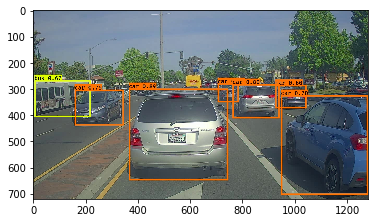

In [16]:
predict(sess, "test.jpg",is_show_info=False)

## 批量绘制图

In [17]:
for i in range(1,121):

    #计算需要在前面填充几个0
    num_fill = int( len("0000") - len(str(1))) + 1
    #对索引进行填充
    filename = str(i).zfill(num_fill) + ".jpg"
    print("当前文件：" + str(filename))

    #开始绘制，不打印信息，不绘制图
    out_scores, out_boxes, out_classes = predict(sess, filename,is_show_info=False,is_plot=False)



print("绘制完成！")

当前文件：0001.jpg


TypeError: cannot unpack non-iterable NoneType object

In [18]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

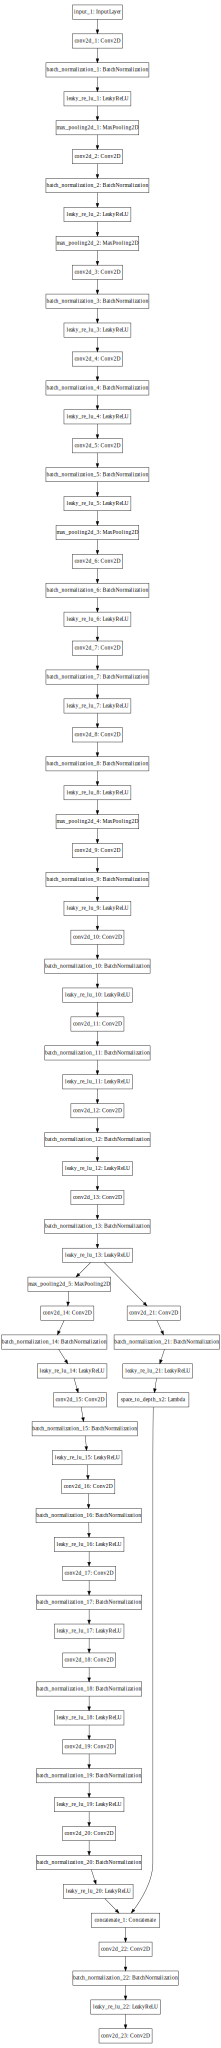

In [19]:
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
plot_model(yolo_model, to_file='yolo_model.png')
SVG(model_to_dot(yolo_model).create(prog='dot', format='svg'))